In [44]:
import pylab as pl
import scipy as sp
import numpy as np
from scipy.linalg import eig
from scipy.io import loadmat
import pdb
import sympy as sym

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
def load_data(fname):
    # load the data
    data = loadmat(fname)
    X,Y = data['X'],data['Y']
    # collapse the time-electrode dimensions
    X = sp.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    # transform the labels to (-1,1)
    Y = sp.sign((Y[0,:]>0) -.5)
    return X,Y

In [47]:
X,Y = load_data('bcidata.mat')
print(X.shape)
print(Y.shape)


(310, 5322)
(5322,)


In [48]:
permidx = sp.random.permutation(sp.arange(X.shape[-1]))
trainpercent = 70.
stopat = sp.floor(Y.shape[-1]*trainpercent/100.)
stopat= int(stopat)

# cut segment data into train and test set into two non-overlapping sets:
Xtrain = X[:, permidx[:stopat], ]
Ytrain = Y[permidx[:stopat]]
Xtest = X[:, permidx[stopat:]]
Ytest = Y[permidx[stopat:]]

In [49]:
size = np.unique(Y).shape[0]
np.random.random(size)

array([0.6815837 , 0.31165163])

In [50]:
def predict(X, Y, w):
    result = np.argmin(np.array([np.sqrt(np.sum((X.T-W)**2, axis=1)) for W in w]),axis=0)
    result[result==0] = -1
    return np.sum(result*Y>0)/len(Y)*100

In [146]:
def train_ncc(X,Y):
    mu_0 = np.mean(X.T[Y==-1],axis=0)
    mu_1 =  np.mean(X.T[Y==1],axis=0)
    return np.array([mu_1, mu_0])

In [201]:
def train_lda(X,Y):
    mu_1, mu_0 = train_ncc(X, Y)
    S_B = (mu_1-mu_0)*((mu_1-mu_0).reshape(-1,1))
    S_W = (X.T[Y==-1]-mu_0.T).T @ (X.T[Y==-1]-mu_0.T)/Y[Y==-1].shape[0]+ (X.T[Y==1]-mu_1.T).T @ (X.T[Y==1]-mu_1.T)/Y[Y==1].shape[0]
    w, eig_vector = np.linalg.eig(np.linalg.inv(S_W).T @ S_B)
    
    idx = w.argsort()[::-1] 
    w = w[idx]
    
    eig_vector = eig_vector[:,idx]
    print(eig_vector.shape)

    b = ((eig_vector@mu_1+eig_vector@mu_0)/2).T
    
    return np.array([b, w])

In [202]:
w_ncc = train_ncc(Xtrain,Ytrain)
w_lda = train_lda(Xtrain,Ytrain)
w_ncc.shape, w_lda.shape

(310, 310)


((2, 310), (2, 310))

In [203]:
def compare_classifiers():
    '''
    compares nearest centroid classifier and linear discriminant analysis
    '''
    fname = 'bcidata.mat'
    X,Y = load_data(fname)

    permidx = sp.random.permutation(sp.arange(X.shape[-1]))
    trainpercent = 70.
    stopat = int(sp.floor(Y.shape[-1]*trainpercent/100.))
    #pdb.set_trace()
    
    X,Y,Xtest,Ytest = X[:,permidx[:stopat]],Y[permidx[:stopat]],X[:,permidx[stopat:]],Y[permidx[stopat:]]

    w_ncc, b_ncc = train_ncc(X, Y)
    w_lda, b_lda = train_lda(X, Y)
    fig = pl.figure(figsize=(12,5))

    ax1 = fig.add_subplot(1,2,1)
    #pl.hold(True)
    ax1.hist(w_ncc.dot(Xtest[:, Ytest<0]))
    ax1.hist(w_ncc.dot(Xtest[:, Ytest>0]))
    ax1.set_xlabel('$w^{T}_{NCC}X$')
    ax1.legend(('non-target','target'))

    ax1.set_title("NCC Acc " + str(predict(Xtest, Ytest,(b_ncc,w_ncc))) + "%")
    ax2 = fig.add_subplot(1,2,2)
    ax2.hist(w_lda.dot(Xtest[:,Ytest<0]))
    ax2.hist(w_lda.dot(Xtest[:,Ytest>0]))
    ax2.set_xlabel('$w^{T}_{LDA}X$')
    ax2.legend(('non-target','target'))
    ax2.set_title("LDA Acc " + str(predict(Xtest, Ytest,(b_lda,w_lda))) + "%")
    pl.savefig('ncc-lda-comparison.pdf')


(310, 310)


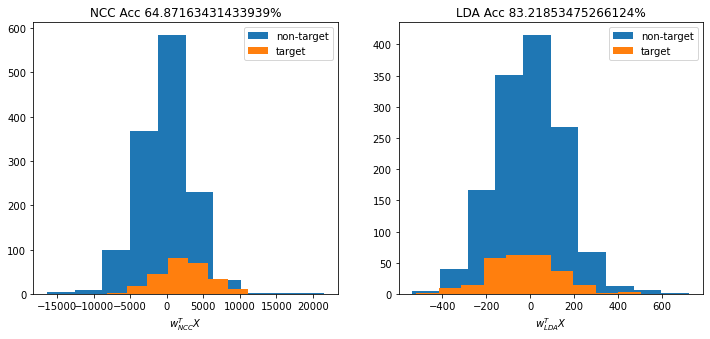

In [204]:
compare_classifiers()

In [ ]:
def crossvalidate(X, Y, f=10,trainfunction=train_lda):
    ''' 
    Test generalization performance of a linear classifier
    Input:	X	data (dims-by-samples)
            Y	labels (1-by-samples)
            f	number of cross-validation folds
            trainfunction 	trains linear classifier
    '''
    ...
    for ifold in sp.arange(f):
        ...
        # train classifier
        w, b = trainfunction(X[:,train],Y[train])
        # compute accuracy on training data
        acc_train[ifold] = predict((w,b), X)
        # compute accuracy on test data
        acc_test[ifold] = ...

    return acc_train, acc_test


In [17]:
X,Y = load_data('bcidata.mat')
crossvalidate(X,Y,f=10,trainfunction=train_lda)

NameError: name 'train' is not defined